In [45]:
import pickle

from gensim.models import Word2Vec
import lightgbm as lgb
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from tqdm.auto import tqdm

In [2]:
df = pd.read_parquet('./data/featurized.parquet')

In [3]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Word2Vec embeddings

In [47]:
def w2v_fit(dataset):
    # group positives by user id to create user to sentence mapping
    user2sentence = df[df['target'] == 1].groupby('msno')['song_id'].apply(list).to_dict()
    w2v = Word2Vec(vector_size=64, window=5)
    w2v.build_vocab(list(user2sentence.values()))
    w2v.train(list(user2sentence.values()), total_examples=w2v.corpus_count, epochs=10)
    return w2v


def get_song_embeddings(w2v):
    return pd.DataFrame(
        {'song_id': list(w2v.wv.key_to_index.keys()), 'song_emb': list(w2v.wv.vectors)}
    )

def get_user_embeddings(w2v, df):
    # User embedding is the mean of its positives' embeddings
    def get_user_embedding(sentence):
        sentence = [x_ for x_ in sentence if x_ in w2v.wv]
        if len(sentence) == 0:
            # Zeros if the user didn't like anything (can be replaced with mean embedding, for example)
            return np.zeros(w2v.vector_size)
        return np.mean(w2v.wv[sentence], axis=0)
    
    return pd.DataFrame(
        df[df['target'] == 1].groupby('msno')['song_id'].apply(get_user_embedding)
    ).reset_index().rename({'song_id': 'user_emb'}, axis=1)

def w2v_predict(w2v, df):
    song_embs = get_song_embeddings(w2v)
    user_embs = get_user_embeddings(w2v, df)
    
    out = df[['msno', 'song_id']]
    out = out.merge(song_embs, on='song_id', how='left').merge(user_embs, on='msno', how='left')
    
    song_embs = np.array(
        [e if not np.isnan(e).any() else np.full(w2v.vector_size, np.nan) for e in out['song_emb'].tolist()]
    )
    user_embs = np.array(
        [e if not np.isnan(e).any() else np.full(w2v.vector_size, np.nan) for e in out['user_emb'].tolist()]
    )
    out.drop(['song_emb', 'user_emb'], axis=1, inplace=True)
    # Dot product
    out['pred'] = np.sum(song_embs * user_embs, axis=1)
    # Fill NaN predictions with median
    out['pred'] = out['pred'].fillna(out['pred'].median())
    # Rescale for ROC-AUC computation
    out['pred'] = (out['pred'] - out['pred'].min()) / (out['pred'].max() - out['pred'].min())
    return out['pred'].values

In [40]:
w2v = w2v_fit(df)

In [41]:
songs = pd.read_csv('./data/songs.csv')

In [42]:
def get_similars_for_song(idx: int):
    if songs.song_id[idx] in w2v.wv:
        return songs[np.isin(songs.song_id, list(map(lambda x: x[0], w2v.wv.similar_by_key(songs.song_id[idx]))))]

In [43]:
# Looks reasonable
get_similars_for_song(0)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
260,Xpq0mPzfHgy7bHdjM72ncRofGofTjHA7GbF9flLKjCc=,209815,798,木匠兄妹最愛情歌,NaN,NaN,52.0
15012,oi6RA3FBriNWPB2B8X2we20NSCNoq18ZWVN95WsIV40=,210279,451,吳雨霏 (Kary Ng),Li Ji Lin,NaN,24.0
33654,uHDSf/ZXVvd1VR1wIx8gKyeZ6IXh9/fFgbhhKDegpO0=,212427,465,深白色2人組,NaN,NaN,3.0
58102,yca9GWzc0kCX9oFoKpwn8f0IOoEbijXcTOJgtRGi35Q=,308035,921,Various Artists,李正帆,厲曼婷,3.0
68886,j+juGRnhjH4k9QRb/EqJNWjcBJ8wTuhVaVrdd2F+4Cg=,248372,458,徐佳瑩 (Lala Hsu),李偲菘,天天,3.0
125908,ckwk2dmYDdzii4H5oTTP1aY+79XCDSrQ4TjAfS1hXD4=,154134,465,盧廣仲 (Crowd Lu),NaN,NaN,3.0
214554,duir/0oduYDsg8nq3czj/97867gW3r1V5SVriV5mdpc=,173011,465,魏如萱 (Waa Wei),魏如萱,魏如萱,3.0
1446615,d2PR77GDSCH2P/rdTLZzqjCcUIhsiRZrxfAlq6C3UYY=,245342,465,羊毛與千葉花,NaN,NaN,17.0
1659043,eOrYV8IpXUuGkKup6UVfS7SoycV/s0hoLV73s9VqwbI=,325799,2022,四分衛 (Quarterback),陳如山,陳如山,3.0
1937582,xfhd4RmJE6p40tlK0HEFsf+yq2fyr0bhIvR6mWATVhA=,244924,921,Various Artists,小蟲,小蟲,3.0


In [44]:
# Same here
get_similars_for_song(1)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
52188,podlycp3c6tOEDw7q8iQBVgvFjiMpkWWXTlXljGdbTY=,212973,444,TWICE,Rado,NaN,31.0
57541,OCf6ja6rohWVy5UBE/XTSOf9YxiMrkCIaLTkFQ+nNf8=,212453,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY| Bekuh BOOM,31.0
93670,0PSoBhrpfwF09qQKvTiItwZNPjOuyL0uoTazKevG8ls=,223375,444,Taeyeon,Kim Ea Na| Christian Vinten| Chelcee Grimes,NaN,31.0
95000,uzU6ntNZT60j0CqFNXTpF6Oo8W3w5UwU/ANEODidW04=,208793,444,TWICE,Black Eyed V,NaN,31.0
96339,JuOOeJJjt5Dgbug0czZ6Mv25AJMtVAukaoxz8T/JX7c=,230373,444,BLACKPINK,TEDDY| SEO WON JIN,TEDDY,31.0
123099,w4Zku7HxtkAKl/BB8H81ZfWOXwnnmVbZBvFZeRPuRUU=,216967,444,BANGTAN BOYS,"Pdogg| Rap Monster| Suga| J-hope| ""hitman""bang...",NaN,31.0
163245,S7MVWawzrMsqfnJdStSPo5rzTn2v8N+AFF+fF+GwprQ=,175171,444,TWICE,Chloe| Noday,NaN,31.0
287598,rcPNzl8xjj74tjZDop961+ugDVJKx4mdgh7L1xJ85FI=,240822,444,BLACKPINK,TEDDY| Bekuh BOOM,TEDDY| Bekuh BOOM,31.0
1401790,kE+FVLsG03zTzYoGVDqTmVkoSKC9DjJwQr2puF6MkOI=,211670,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY| Bekuh BOOM,31.0
1701616,ZmO/ZHR6dKRh2ugrVt4mmHho11pz2ksQH0eYBdtRZ68=,175171,444,TWICE,Sebastian Thott| Didrik Thott| Andreas Oberg| ...,NaN,31.0


## Word2Vec as a predictor model

In [49]:
# 5 fold CV
preds = np.zeros_like(y, dtype=float)
models = []
for train_idx, test_idx in tqdm(KFold(5, shuffle=True).split(X, y), total=5):
    w2v = w2v_fit(df.iloc[train_idx])
    preds[test_idx] = w2v_predict(w2v, df.iloc[test_idx])

  0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
# OOF ROC-AUC
roc_auc_score(y, preds)

0.6336243659705524

In [51]:
res_ds = pd.DataFrame({'msno': X['msno'], 'true': y, 'pred': preds})
group_aucs = res_ds.groupby('msno').apply(
    lambda x: roc_auc_score(x.true, x.pred) if len(set(x.true)) > 1 else np.nan
)
# Mean User ROC-AUC
np.nanmean(group_aucs)

0.7334474199326709

Интересно, что по обычному ROC-AUC LGBM сильно лучше (~0.8), однако по Mean User AUC впереди эмбеддинги Word2Vec.
Скорее всего такое поведение обуславливается извлеченными фичами. Word2Vec учитывает частоты для песен, юзеров, а LGBM использует более "глобальные" фичи, вроде имен исполнителей, композиторов, длительности трека и т.д.

## Ensembling

In [64]:
# LGB params from kaggle
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.2 ,
    'verbose': 0,
    'num_leaves': 100,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_bin': 256,
    'num_rounds': 100,
    'metric' : 'auc'
}

In [73]:
# 5 fold CV
preds = np.zeros_like(y, dtype=float)
models = []
test_sets = []
for train_idx, test_idx in KFold(5, shuffle=True).split(X, y):
    w2v = w2v_fit(df.iloc[train_idx])
    
    X_train = X.iloc[train_idx]
    X_train['w2v_pred'] = w2v_predict(w2v, df.iloc[train_idx])
    X_test = X.iloc[test_idx]
    X_test['w2v_pred'] = w2v_predict(w2v, df.iloc[test_idx])
    
    test_sets.append((X_test, y.iloc[test_idx]))

    train_ds = lgb.Dataset(X_train, y.iloc[train_idx])
    test_ds = lgb.Dataset(X_test, y.iloc[test_idx])
    # We can use early stopping because of the existence of the holdout set ("./data/test.csv")
    # However, 100 boosting rounds is too few and the model is still underfit
    model = lgb.train(params, train_set=train_ds, valid_sets=test_ds, verbose_eval=5, early_stopping_rounds=25)
    models.append((w2v, model))
    preds[test_idx] = model.predict(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.291236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's auc: 0.754784
[10]	valid_0's auc: 0.768856
[15]	valid_0's auc: 0.77958
[20]	valid_0's auc: 0.790309
[25]	valid_0's auc: 0.796326
[30]	valid_0's auc: 0.801294
[35]	valid_0's auc: 0.804328
[40]	valid_0's auc: 0.807672
[45]	valid_0's auc: 0.809622
[50]	valid_0's auc: 0.811146
[55]	valid_0's auc: 0.812908
[60]	valid_0's auc: 0.814062
[65]	valid_0's auc: 0.815139
[70]	valid_0's auc: 0.816183
[75]	valid_0's auc: 0.81709
[80]	valid_0's auc: 0.817948
[85]	valid_0's auc: 0.818479
[90]	valid_0's auc: 0.819228
[95]	valid_0's auc: 0.819958
[100]	valid_0's auc: 0.820393
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.820492



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's auc: 0.75427
[10]	valid_0's auc: 0.764989
[15]	valid_0's auc: 0.77763
[20]	valid_0's auc: 0.786098
[25]	valid_0's auc: 0.792197
[30]	valid_0's auc: 0.797324
[35]	valid_0's auc: 0.800023
[40]	valid_0's auc: 0.802772
[45]	valid_0's auc: 0.805262
[50]	valid_0's auc: 0.806311
[55]	valid_0's auc: 0.808203
[60]	valid_0's auc: 0.809793
[65]	valid_0's auc: 0.810518
[70]	valid_0's auc: 0.811796
[75]	valid_0's auc: 0.813278
[80]	valid_0's auc: 0.814162
[85]	valid_0's auc: 0.814885
[90]	valid_0's auc: 0.815502
[95]	valid_0's auc: 0.815857
[100]	valid_0's auc: 0.817009
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.817009



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's auc: 0.760876
[10]	valid_0's auc: 0.776045
[15]	valid_0's auc: 0.786452
[20]	valid_0's auc: 0.796487
[25]	valid_0's auc: 0.801893
[30]	valid_0's auc: 0.806671
[35]	valid_0's auc: 0.809476
[40]	valid_0's auc: 0.812861
[45]	valid_0's auc: 0.815385
[50]	valid_0's auc: 0.817199
[55]	valid_0's auc: 0.818579
[60]	valid_0's auc: 0.819804
[65]	valid_0's auc: 0.820964
[70]	valid_0's auc: 0.822034
[75]	valid_0's auc: 0.823357
[80]	valid_0's auc: 0.824076
[85]	valid_0's auc: 0.824657
[90]	valid_0's auc: 0.825273
[95]	valid_0's auc: 0.825643
[100]	valid_0's auc: 0.826265
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.826265



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's auc: 0.760382
[10]	valid_0's auc: 0.776128
[15]	valid_0's auc: 0.786436
[20]	valid_0's auc: 0.796428
[25]	valid_0's auc: 0.803011
[30]	valid_0's auc: 0.807868
[35]	valid_0's auc: 0.811017
[40]	valid_0's auc: 0.813708
[45]	valid_0's auc: 0.816435
[50]	valid_0's auc: 0.818085
[55]	valid_0's auc: 0.819751
[60]	valid_0's auc: 0.820926
[65]	valid_0's auc: 0.821965
[70]	valid_0's auc: 0.822761
[75]	valid_0's auc: 0.82375
[80]	valid_0's auc: 0.824768
[85]	valid_0's auc: 0.825433
[90]	valid_0's auc: 0.826298
[95]	valid_0's auc: 0.826877
[100]	valid_0's auc: 0.827421
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.827487



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Found `num_rounds` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.276687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 25 rounds
[5]	valid_0's auc: 0.753968
[10]	valid_0's auc: 0.767139
[15]	valid_0's auc: 0.778629
[20]	valid_0's auc: 0.788219
[25]	valid_0's auc: 0.794765
[30]	valid_0's auc: 0.799838
[35]	valid_0's auc: 0.802684
[40]	valid_0's auc: 0.805911
[45]	valid_0's auc: 0.808597
[50]	valid_0's auc: 0.810185
[55]	valid_0's auc: 0.811578
[60]	valid_0's auc: 0.813068
[65]	valid_0's auc: 0.813884
[70]	valid_0's auc: 0.815049
[75]	valid_0's auc: 0.815939
[80]	valid_0's auc: 0.817013
[85]	valid_0's auc: 0.817343
[90]	valid_0's auc: 0.818121
[95]	valid_0's auc: 0.818675
[100]	valid_0's auc: 0.819228
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.81931


In [74]:
# OOF ROC-AUC
roc_auc_score(y, preds)

0.8180748782406358

In [75]:
res_ds = pd.DataFrame({'msno': X['msno'], 'true': y, 'pred': preds})
group_aucs = res_ds.groupby('msno').apply(
    lambda x: roc_auc_score(x.true, x.pred) if len(set(x.true)) > 1 else np.nan
)
# Mean User ROC-AUC
np.nanmean(group_aucs)

0.778340379407677

Блендингом Word2Vec-а с LGBM, удалось улучшить обе метрики

In [76]:
import shap

In [77]:
explainer = shap.TreeExplainer(models[0][1])

In [78]:
out = explainer.shap_values(*test_sets[0])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


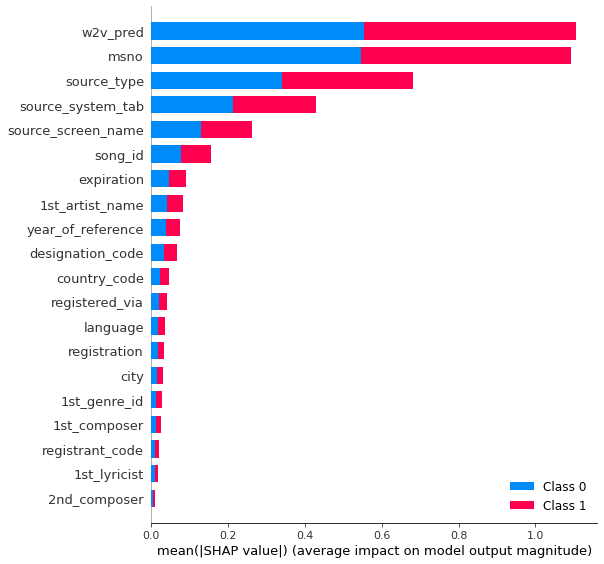

In [80]:
shap.summary_plot(out, test_sets[0][0])

Хотел посчитать out-of-fold shap values, но, к сожалению, это занимает очень много времени, поэтому оставлю для одного фолда. Вряд ли мы увидим сильно отличающиеся результаты на остальных фолдах, так как у нас немного фич и метрики на фолдах довольно близки

Видно, что предсказание Word2Vec полезно, так как оно стало самой важной фичей. Опять же, скорее всего, потому что фичи для LGBM и фичи из Word2Vec сильно отличаются, а значит последние докидывают информацию 